In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf

from edward.models import Poisson,Gamma
import matplotlib.pyplot as plt

In [2]:
def build_toy_dataset(users,items):
    
    threshold = 0.8
    dataset = np.random.uniform(size=[users,items])
    
    for i in range(0,users):
        for j in range(0,items):
            if dataset[i,j] < threshold:
                dataset[i,j] = 0
            else:
                dataset[i,j] = 1
    
    test_fraction = 0.5
    train_mask = np.random.uniform(size=[users,items])
    
    for i in range(0,users):
        for j in range(0,items):
            if train_mask[i,j] < test_fraction:
                train_mask[i,j] = 1
            else:
                train_mask[i,j] = 0
    
    return dataset,train_mask

In [3]:
def evaluate(dataset,train_mask,result,ndcg):
    
    ndcg.append(0)
    for i in range(0,users):
        sort_index = np.argsort(result[i])[::-1]
        score = 0
        norm = 0
        count = 1
        
        for j in range(0,items):
                if train_mask[i,sort_index[j]] == 0 and dataset[i,sort_index[j]] == 1:
                    count += 1
                    norm += 1.0/np.log2(count)
                    score += 1.0/np.log2(j+2)
        ndcg[-1] += score/norm
    ndcg[-1] /= users

In [12]:
training_iter = 1000
test_after_iter = 100
users = 100
items = 100
k = 5 #latent factors
dataset,train_mask = build_toy_dataset(users,items)
training_data = dataset*train_mask
ndcg = []

In [13]:
a = 0.1
b = 0.1
theta = Gamma(concentration = a*tf.ones([users,k]), rate = a*tf.ones([users,k]))
beta = Gamma(concentration = b*tf.ones([items,k]), rate = b*tf.ones([items,k]))
x = Poisson(rate = tf.matmul(theta,beta,transpose_b=True))

In [14]:
qtheta = Gamma(concentration = tf.Variable(tf.random_uniform([users,k],minval = 0.01, maxval = 1.0)), rate = tf.Variable(tf.random_uniform([users,k],minval = 0.01, maxval = 1.0)))
qbeta = Gamma(concentration = tf.Variable(tf.random_uniform([items,k],minval = 0.01, maxval = 1.0)), rate = tf.Variable(tf.random_uniform([items,k],minval = 0.01, maxval = 1.0)))

In [24]:
inference = ed.ReparameterizationKLqp({theta:qtheta,beta:qbeta},data={x:training_data})
inference.initialize(n_iter=training_iter)

In [25]:
sess = ed.get_session()
tf.global_variables_initializer().run()
for i in range(1,inference.n_iter):
    inference.update()
    if i%test_after_iter == 0:
        print("Currently at %d iteration"%(i))
        theta_samples = sess.run(qtheta.sample(10))
        beta_samples = sess.run(qbeta.sample(10))
        result = np.zeros([users,items])
        for j in range(0,10):
            result += np.matmul(theta_samples[j],np.transpose(beta_samples[j]))
        result /= 10.0
        #print(beta_samples)
        evaluate(dataset,train_mask,result,ndcg)

Currently at 100 iteration
Currently at 200 iteration
Currently at 300 iteration
Currently at 400 iteration
Currently at 500 iteration
Currently at 600 iteration
Currently at 700 iteration
Currently at 800 iteration
Currently at 900 iteration


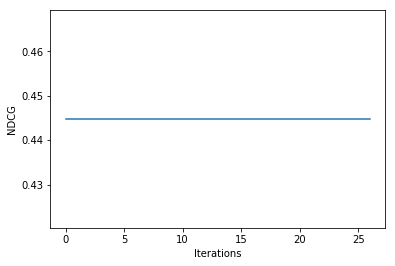

In [26]:
plt.plot(ndcg)
plt.xlabel("Iterations")
plt.ylabel("NDCG")
plt.show()


In [ ]:
print(ndcg)